In [59]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import time
from scipy.stats import randint, uniform

# Ignorar warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../data/processed/complete_merged.csv')
df.head()


,Country,Year,Agricultural production index (2014-2016=100),"Balance of payments, current account (million US$)",CPI: Consumer Price Index (2010=100),Economy: Agriculture (% of Gross Value Added),Economy: Industry (% of Gross Value Added),Economy: Services and other activity (% of GVA),Employment in agriculture (% of employed),Employment in industry (% of employed),...,Capital city,Exchange rate (per US$),National currency,"Pop. density (per km2, 2024)","Population (000, 2024)",Region,Sex ratio (m per 100 f),Surface area (km2),UN membership date,Capital_city_pop
0,Afghanistan,2015.0,96.0,4193.0,133.0,22.0,9.6,68.3,44.6,20.7,...,Kabul,77.1,Afghani (AFN),65.7,42648.0,Southern Asia,102.0,652864.0,1946-11-19,4114.0
1,Afghanistan,2020.0,112.0,3137.0,150.0,31.4,13.6,55.0,46.0,18.5,...,Kabul,77.1,Afghani (AFN),65.7,42648.0,Southern Asia,102.0,652864.0,1946-11-19,4114.0
2,Afghanistan,2024.0,111.0,NaN,NaN,35.5,16.9,47.5,46.6,18.3,...,Kabul,77.1,Afghani (AFN),65.7,42648.0,Southern Asia,102.0,652864.0,1946-11-19,4114.0
3,Albania,2015.0,100.0,980.0,111.0,22.5,24.8,52.7,41.3,18.7,...,Tirana,93.9,Lek (ALL),101.9,2792.0,Southern Europe,97.8,28748.0,1955-12-14,484.6
4,Albania,2020.0,106.0,1315.0,121.0,21.9,22.9,55.1,36.2,20.6,...,Tirana,93.9,Lek (ALL),101.9,2792.0,Southern Europe,97.8,28748.0,1955-12-14,484.6


In [6]:
#Education
df["Education: Primary gross enrol. ratio - average"] = (df["Education: Primary gross enrol. ratio - Female (per 100 pop.)"] + df["Education: Primary gross enrol. ratio - Male (per 100 pop.)"]) / 2
df["Education: Primary gross enrol. ratio - brecha"] = df["Education: Primary gross enrol. ratio - Female (per 100 pop.)"] - df["Education: Primary gross enrol. ratio - Male (per 100 pop.)"]
df["Education: Upper Sec. gross enrol. ratio - average"] = (df["Education: Upper Sec. gross enrol. ratio - Female (per 100 pop.)"] + df['Education: Upper Sec. gross enrol. ratio - Male (per 100 pop.)']) / 2
df["Education: Upper Sec. gross enrol brecha"] = df["Education: Upper Sec. gross enrol. ratio - Female (per 100 pop.)"] - df["Education: Upper Sec. gross enrol. ratio - Male (per 100 pop.)"]
df["Education: Lower Sec. gross enrol. ratio - average"] = (df["Education: Lower Sec. gross enrol. ratio - Female (per 100 pop.)"] + df["Education: Lower Sec. gross enrol. ratio - Male (per 100 pop.)"]) / 2
df["Education: Lower Sec. gross enrol brecha"] = df["Education: Lower Sec. gross enrol. ratio - Female (per 100 pop.)"] - df["Education: Lower Sec. gross enrol. ratio - Male (per 100 pop.)"]
#Life Expectancy
df["Life expectancy at birth - average"] = (df["Life expectancy at birth - Female (years)"] + df["Life expectancy at birth - Male (years)"])/2
df["Life expectancy at birth - brecha"] = df["Life expectancy at birth - Female (years)"] - df["Life expectancy at birth - Male (years)"]
#
df.drop(columns=["Education: Primary gross enrol. ratio - Female (per 100 pop.)",
                 "Education: Primary gross enrol. ratio - Male (per 100 pop.)",
                 "Education: Upper Sec. gross enrol. ratio - Female (per 100 pop.)",
                 "Education: Upper Sec. gross enrol. ratio - Male (per 100 pop.)",
                 "Education: Lower Sec. gross enrol. ratio - Female (per 100 pop.)",
                 "Education: Lower Sec. gross enrol. ratio - Male (per 100 pop.)",
                 "Life expectancy at birth - Female (years)",
                 "Life expectancy at birth - Male (years)",
                    ], inplace=True)

In [7]:
# Basic information about the dataset and target variable
print("Dataset shape:", df.shape)
print(f"\nTarget variable: Life expectancy at birth - average")
print(f"Target variable statistics:")
target_stats = df["Life expectancy at birth - average"].describe()
print(target_stats)
print(f"\nData types:")
print(df.dtypes.value_counts())
print(f"\nMissing values summary:")
print(df.isnull().sum().sum(), "total missing values")
print(f"{(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}% of data is missing")
print(f"\nTarget variable missing values: {df['Life expectancy at birth - average'].isnull().sum()}")
print(f"Available target observations: {df['Life expectancy at birth - average'].notna().sum()}")

Dataset shape: (696, 79)

Target variable: Life expectancy at birth - average
Target variable statistics:
count    690.000000
mean      73.065217
std        7.474043
min       39.900000
25%       67.912500
50%       74.400000
75%       78.450000
max       86.600000
Name: Life expectancy at birth - average, dtype: float64

Data types:
float64    74
object      5
Name: count, dtype: int64

Missing values summary:
10082 total missing values
18.34% of data is missing

Target variable missing values: 6
Available target observations: 690


# Exploratory Data Analysis for Life Expectancy Regression

## 1. Target Variable Analysis
Let's analyze the distribution and characteristics of our target variable `Life expectancy at birth - average`.

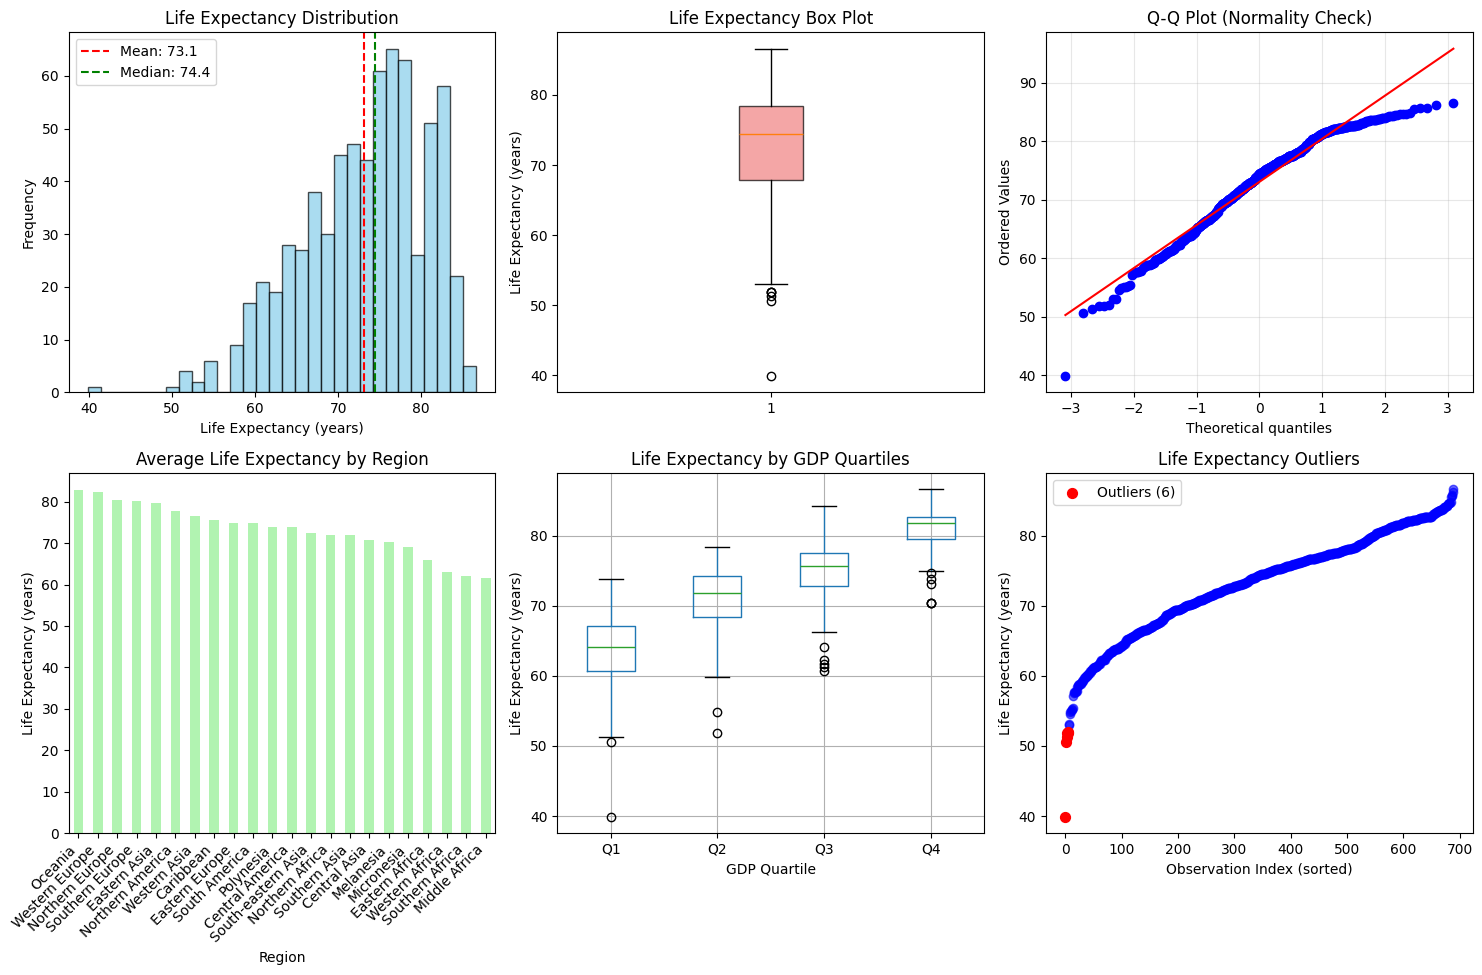


Target Variable Statistical Summary:
Mean: 73.07 years
Median: 74.40 years
Standard deviation: 7.47 years
Min: 39.90 years
Max: 86.60 years
Range: 46.70 years
Skewness: -0.629
Kurtosis: 0.090

Outliers detected: 6
Outlier countries: ['Central African Republic', 'Central African Republic', 'Chad', 'Lesotho', 'Nigeria', 'South Sudan']


In [8]:
# Target variable analysis
plt.figure(figsize=(15, 10))

# Life expectancy distribution
plt.subplot(2, 3, 1)
life_exp_clean = df["Life expectancy at birth - average"].dropna()
plt.hist(life_exp_clean, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Life Expectancy Distribution')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Frequency')
plt.axvline(life_exp_clean.mean(), color='red', linestyle='--', label=f'Mean: {life_exp_clean.mean():.1f}')
plt.axvline(life_exp_clean.median(), color='green', linestyle='--', label=f'Median: {life_exp_clean.median():.1f}')
plt.legend()

# Box plot
plt.subplot(2, 3, 2)
plt.boxplot(life_exp_clean, patch_artist=True, 
            boxprops=dict(facecolor='lightcoral', alpha=0.7))
plt.title('Life Expectancy Box Plot')
plt.ylabel('Life Expectancy (years)')

# Q-Q plot for normality
plt.subplot(2, 3, 3)
from scipy import stats
stats.probplot(life_exp_clean, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(True, alpha=0.3)

# Life expectancy by continent/region (if available)
plt.subplot(2, 3, 4)
region_life_exp = df.groupby('Region')["Life expectancy at birth - average"].mean().sort_values(ascending=False)
region_life_exp.plot(kind='bar', color='lightgreen', alpha=0.7)
plt.title('Average Life Expectancy by Region')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Life Expectancy (years)')
# Distribution by GDP quartiles
plt.subplot(2, 3, 5)
df_temp = df[df["Life expectancy at birth - average"].notna() & df['GDP per capita (current US$)'].notna()].copy()
df_temp['gdp_quartile'] = pd.qcut(df_temp["GDP per capita (current US$)"], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df_temp.boxplot(column="Life expectancy at birth - average", by='gdp_quartile', ax=plt.gca())
plt.title('Life Expectancy by GDP Quartiles')
plt.suptitle('')  # Remove automatic title
plt.xlabel('GDP Quartile')
plt.ylabel('Life Expectancy (years)')

# Outliers analysis
plt.subplot(2, 3, 6)
Q1 = life_exp_clean.quantile(0.25)
Q3 = life_exp_clean.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = life_exp_clean[(life_exp_clean < lower_bound) | (life_exp_clean > upper_bound)]

plt.scatter(range(len(life_exp_clean)), life_exp_clean.sort_values(), alpha=0.6, color='blue')
if len(outliers) > 0:
    outlier_indices = [list(life_exp_clean.sort_values()).index(x) for x in outliers if x in life_exp_clean.sort_values().values]
    plt.scatter(outlier_indices, outliers, color='red', s=50, label=f'Outliers ({len(outliers)})')
    plt.legend()
plt.title('Life Expectancy Outliers')
plt.xlabel('Observation Index (sorted)')
plt.ylabel('Life Expectancy (years)')

plt.tight_layout()
plt.savefig("../src/visualization/regression/target_var_analysis.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Statistical summary
print(f"\nTarget Variable Statistical Summary:")
print(f"Mean: {life_exp_clean.mean():.2f} years")
print(f"Median: {life_exp_clean.median():.2f} years")
print(f"Standard deviation: {life_exp_clean.std():.2f} years")
print(f"Min: {life_exp_clean.min():.2f} years")
print(f"Max: {life_exp_clean.max():.2f} years")
print(f"Range: {life_exp_clean.max() - life_exp_clean.min():.2f} years")
print(f"Skewness: {life_exp_clean.skew():.3f}")
print(f"Kurtosis: {life_exp_clean.kurtosis():.3f}")
if len(outliers) > 0:
    print(f"\nOutliers detected: {len(outliers)}")
    print(f"Outlier countries: {list(df[df['Life expectancy at birth - average'].isin(outliers)]['Country'].values)}")
else:
    print(f"\nNo outliers detected using IQR method")

Existen paises con expectativa de vida significantemente mas baja que el resto 

In [9]:
general_info = ['Capital city', 'Exchange rate (per US$)',
       'National currency', 'Pop. density (per km2, 2024)',
       'Population (000, 2024)', 'Region', 'Sex ratio (m per 100 f)',
       'Surface area (km2)', 'UN membership date', 'Capital_city_pop'
       ]

social_indicators = [
    'Education: Government expenditure (% of GDP)',
    'Fertility rate, total (live births per woman)',
    'Health: Current expenditure (% of GDP)',
    'Health: Physicians (per 1 000 pop.)',
    'Intentional homicide rate (per 100 000 pop.)',
    'Population growth rate (average annual %)',
    'Refugees and others of concern to UNHCR (000)',
    'Seats held by women in national parliaments (%)',
    'Under five mortality rate (per 1000 live births)',
    'Urban population (% of total population)',
    "Education: Primary gross enrol. ratio - average",
    "Education: Primary gross enrol. brecha",
    "Education: Upper Sec. gross enrol. ratio - average",
    "Education: Upper Sec. gross enrol brecha",
    "Education: Lower Sec. gross enrol. ratio - average",
    "Education: Lower Sec. gross enrol brecha",
    'International migrant stock (% of total pop.)',
    "Life expectancy at birth - average",
    "Life expectancy at birth - brecha",
    'Population age distribution - 0-14 years (%)',
    'Population age distribution - 60+ years (%)',
    ]

economic_indicators = [
    'Agricultural production index (2014-2016=100)',
    'Balance of payments, current account (million US$)',
    'CPI: Consumer Price Index (2010=100)',
    'Economy: Agriculture (% of Gross Value Added)',
    'Economy: Industry (% of Gross Value Added)',
    'Economy: Services and other activity (% of GVA)',
    'Employment in agriculture (% of employed)',
    'Employment in industry (% of employed)',
    'Employment in services (% employed)',
    'GDP growth rate (annual %, const. 2015 prices)',
    'GDP per capita (current US$)',
    'GDP: Gross domestic product (million current US$)',
    'International trade: balance (million current US$)',
    'International trade: exports (million current US$)',
    'International trade: imports (million current US$)',
    'Unemployment (% of labour force)',
    'Labour force participation rate - Female (per 100 pop.)',
    'Labour force participation rate - Male (per 100 pop.)',
    ]

env_infrastructure_indicators = [
    'Energy production, primary (Petajoules)',
    'Energy supply per capita (Gigajoules)',
    'Forested area (% of land area)',
    'Important sites for terrestrial biodiversity protected (%)',
    'Individuals using the Internet (per 100 inhabitants)',
    'Net Official Development Assist. disbursed (% of GNI)',
    'Net Official Development Assist. received (% of GNI)',
    'Research & Development expenditure (% of GDP)',
    'Threatened species (number)',
    'Tourist/visitor arrivals at national borders (000)',
    'CO2 emission estimates - Total (million tons)',
    'CO2 emission estimates - Per capita (tons per capita)',
    'Pop. using safely managed drinking water - Urban (%)',
    'Pop. using safely managed drinking water - Rural (%)',
    'Pop. using safely managed sanitation - Urban (%)',
    'Pop. using safely managed sanitation - Rural (%)',
    ]

## 3. Feature Analysis and Correlation with Life Expectancy
Let's analyze how different features correlate with life expectancy.

## 2. Correlation Matrices by Variable Groups
Let's analyze the correlation between life expectancy and each group of indicators separately.

In [10]:
# Función para crear matriz de correlación por grupo
def create_correlation_matrix_by_group(df, variable_groups, target_var="Life expectancy at birth - average", min_completeness=0.8):
    """
    Crea matrices de correlación para cada grupo de variables vs la variable objetivo
    Automáticamente filtra variables con menos del 80% de datos completos
    """
    results = {}
    
    for group_name, variables in variable_groups.items():
        
        # Filtrar variables que existen en el dataset y tienen datos suficientes (≥80%)
        available_vars = []
        filtered_vars = []
        
        for var in variables:
            if var in df.columns and var != target_var:
                completeness = df[var].notna().sum() / len(df)
                if completeness >= min_completeness:
                    available_vars.append(var)
                else:
                    filtered_vars.append((var, completeness))
        
        # Crear dataset con variables válidas + target
        group_vars = available_vars + [target_var]
        group_df = df[group_vars].copy()
        
        # Calcular matriz de correlación
        corr_matrix = group_df.corr()
        
        # Extraer correlaciones con la variable objetivo
        target_correlations = corr_matrix[target_var].drop(target_var).sort_values(key=abs, ascending=False)
        
        # Guardar resultados
        results[group_name] = {
            'variables': available_vars,
            'correlation_matrix': corr_matrix,
            'target_correlations': target_correlations,
            'sample_size': group_df.dropna().shape[0]
        }
        
    return results

# Definir grupos de variables
variable_groups = {
    "Indicadores Sociales": social_indicators,
    "Indicadores Económicos": economic_indicators,
    "Indicadores Ambientales y de Infraestructura": env_infrastructure_indicators
}

# Remover la variable objetivo de los grupos si está presente
for group_name, variables in variable_groups.items():
    if "Life expectancy at birth - average" in variables:
        variables.remove("Life expectancy at birth - average")

# Visualización de matrices de correlación para cada grupo
def plot_correlation_matrices(correlation_results, target_var="Life expectancy at birth - average"):
    """
    Crea visualizaciones compactas de las matrices de correlación para cada grupo
    Ordenadas por correlación absoluta, solo mostrando colores y valores
    """
    n_groups = len(correlation_results)
    
    if n_groups == 0:
        print("No hay resultados para visualizar")
        return
    
    # Configurar subplots con menos espacio horizontal
    fig, axes = plt.subplots(1, n_groups, figsize=(4*n_groups, 10))
    if n_groups == 1:
        axes = [axes]
    
    for i, (group_name, results) in enumerate(correlation_results.items()):
        ax = axes[i]
        
        # Obtener matriz de correlación
        corr_matrix = results['correlation_matrix']
        
        # Filtrar y ordenar correlaciones por valor absoluto (descendente)
        target_corrs = corr_matrix[target_var].drop(target_var)
        target_corrs_sorted = target_corrs.reindex(target_corrs.abs().sort_values(ascending=False).index)
        
        # Crear heatmap vertical más compacto
        corr_data = target_corrs_sorted.values.reshape(-1, 1)
        
        # Heatmap sin bordes y más compacto
        im = ax.imshow(corr_data, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        
        # Configurar etiquetas con nombres completos
        ax.set_yticks(range(len(target_corrs_sorted)))
        ax.set_yticklabels(target_corrs_sorted.index, fontsize=9, ha='right')
        ax.set_xticks([0])
        ax.set_xticklabels(['Correlación'], fontsize=10)
        ax.set_title(f'{group_name}\n({len(target_corrs_sorted)} variables)', fontsize=11, pad=15)
        
        # Añadir valores de correlación con mejor contraste
        for j, (var_name, corr_val) in enumerate(target_corrs_sorted.items()):
            # Determinar color del texto basado en la intensidad del fondo
            color = 'white' if abs(corr_val) > 0.4 else 'black'
            ax.text(0, j, f'{corr_val:.3f}', ha='center', va='center', 
                   color=color, fontweight='bold', fontsize=9)
        
        # Remover ticks y bordes para apariencia más limpia
        ax.set_xlim(-0.5, 0.5)
        ax.tick_params(left=False, bottom=False)
        
        # Ajustar márgenes para mostrar nombres completos
        plt.setp(ax.get_yticklabels(), fontsize=8, wrap=True)
    
    # Añadir colorbar
    plt.tight_layout()
    fig.subplots_adjust(right=0.85, left=0.15)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Coeficiente de Correlación', rotation=270, labelpad=15)
    cbar.ax.tick_params(labelsize=9)
    
    plt.show()

# Ejecutar análisis con filtrado automático usando el umbral configurado
correlation_results = create_correlation_matrix_by_group(df, variable_groups, min_completeness=0.8)



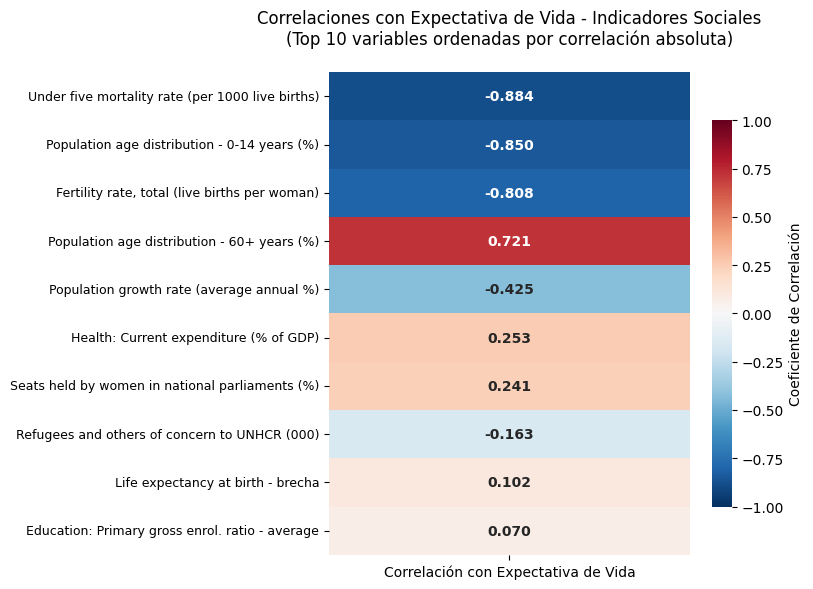

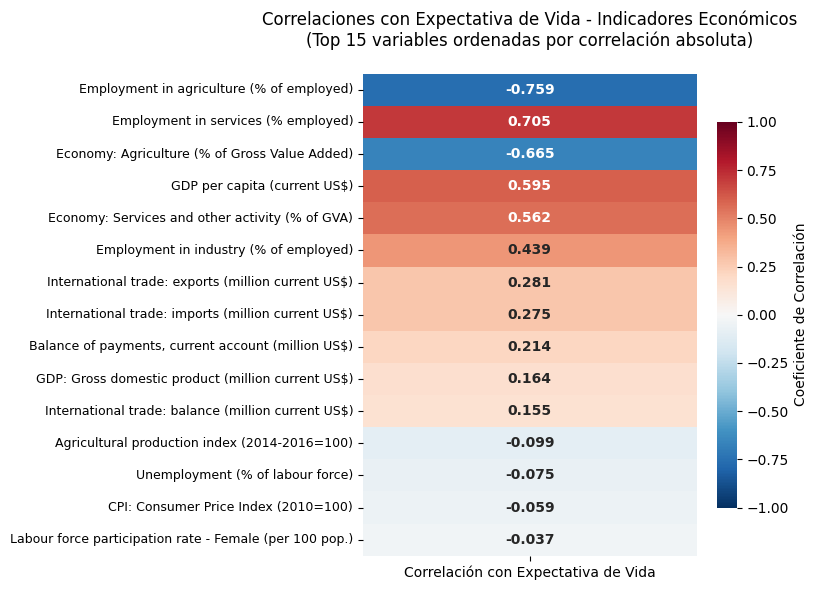

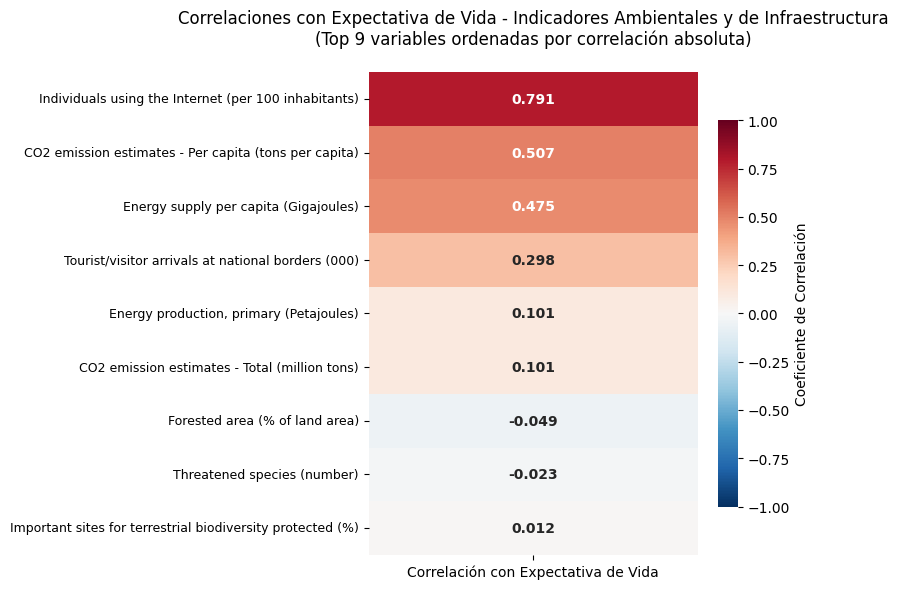

In [ ]:
# Crear heatmaps detallados y compactos para cada grupo
def plot_detailed_correlation_heatmaps(correlation_results, target_var="Life expectancy at birth - average"):
    """
    Crea heatmaps detallados y compactos de correlación para cada grupo
    Ordenados por correlación absoluta, formato optimizado para mostrar nombres completos
    """
    for group_name, results in correlation_results.items():
        # Obtener correlaciones con la variable objetivo
        target_corrs = results['target_correlations']
        
        # Ordenar por correlación absoluta (descendente) y tomar top 15
        target_corrs_sorted = target_corrs.reindex(target_corrs.abs().sort_values(ascending=False).index)
        top_vars = target_corrs_sorted.head(15)
        
        if len(top_vars) == 0:
            continue
            
        # Crear heatmap más compacto
        fig, ax = plt.subplots(figsize=(8, max(6, len(top_vars) * 0.4)))
        
        # Preparar datos para el heatmap
        corr_values = top_vars.values.reshape(-1, 1)
        
        # Crear heatmap con seaborn para mejor control
        sns.heatmap(corr_values, 
                   annot=True, 
                   fmt='.3f',
                   cmap='RdBu_r', 
                   center=0,
                   vmin=-1, 
                   vmax=1,
                   cbar_kws={'label': 'Coeficiente de Correlación', 'shrink': 0.8},
                   yticklabels=top_vars.index,
                   xticklabels=['Correlación con Expectativa de Vida'],
                   square=False,
                   ax=ax,
                   annot_kws={'fontsize': 10, 'fontweight': 'bold'})
        
        # Configurar título y etiquetas
        ax.set_title(f'Correlaciones con Expectativa de Vida - {group_name}\n'
                    f'(Top {len(top_vars)} variables ordenadas por correlación absoluta)', 
                    fontsize=12, pad=20)
        ax.set_ylabel('')
        ax.set_xlabel('')
        
        # Ajustar etiquetas del eje Y para mejor legibilidad
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9, ha='right')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
        
        plt.tight_layout()
        plt.savefig(f"../src/visualization/regression/corr_test_{group_name}.png", dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
# Ejecutar visualizaciones detalladas
plot_detailed_correlation_heatmaps(correlation_results)

In [13]:
# Comparación de los mejores predictores entre grupos
def compare_best_predictors_across_groups(correlation_results, top_n=5):
    """
    Compara los mejores predictores de cada grupo
    """
    print(f"\n{'='*80}")
    print(f"COMPARACIÓN DE LOS MEJORES PREDICTORES ENTRE GRUPOS (TOP {top_n})")
    print(f"{'='*80}")
    
    all_predictors = []
    
    for group_name, results in correlation_results.items():
        target_corrs = results['target_correlations']
        top_predictors = target_corrs.head(top_n)
        
        print(f"\n🏆 {group_name}:")
        print("-" * 50)
        
        for i, (var, corr) in enumerate(top_predictors.items()):
            direction = "↑" if corr > 0 else "↓"
            strength = "🟢" if abs(corr) > 0.7 else "🟡" if abs(corr) > 0.5 else "🟠" if abs(corr) > 0.3 else "🔴"
            print(f"  {i+1}. {strength} {direction} {corr:6.3f} | {var[:60]}")
            
            all_predictors.append({
                'group': group_name,
                'variable': var,
                'correlation': corr,
                'abs_correlation': abs(corr)
            })
    
    # Crear ranking global
    all_predictors_df = pd.DataFrame(all_predictors)
    global_ranking = all_predictors_df.sort_values('abs_correlation', ascending=False)
    
    print(f"\n🌟 RANKING GLOBAL - TOP {top_n*len(correlation_results)} PREDICTORES:")
    print("=" * 80)
    
    for i, row in enumerate(global_ranking.head(top_n*len(correlation_results)).iterrows()):
        data = row[1]
        direction = "↑" if data['correlation'] > 0 else "↓"
        strength = "🟢" if data['abs_correlation'] > 0.7 else "🟡" if data['abs_correlation'] > 0.5 else "🟠" if data['abs_correlation'] > 0.3 else "🔴"
        group_short = data['group'][:20] + '...' if len(data['group']) > 20 else data['group']
        var_short = data['variable'][:40] + '...' if len(data['variable']) > 40 else data['variable']
        
        print(f"{i+1:2d}. {strength} {direction} {data['correlation']:6.3f} | {var_short:<45} | {group_short}")
    
    # Análisis por grupo
    print(f"\n📊 ANÁLISIS POR GRUPO:")
    print("=" * 50)
    
    for group_name in correlation_results.keys():
        group_data = all_predictors_df[all_predictors_df['group'] == group_name]
        avg_corr = group_data['abs_correlation'].mean()
        max_corr = group_data['abs_correlation'].max()
        min_corr = group_data['abs_correlation'].min()
        
        print(f"{group_name}:")
        print(f"  • Correlación promedio: {avg_corr:.3f}")
        print(f"  • Correlación máxima:   {max_corr:.3f}")
        print(f"  • Correlación mínima:   {min_corr:.3f}")
        print()
    
    return global_ranking

# Ejecutar comparación
global_predictors_ranking = compare_best_predictors_across_groups(correlation_results)


COMPARACIÓN DE LOS MEJORES PREDICTORES ENTRE GRUPOS (TOP 5)

🏆 Indicadores Sociales:
--------------------------------------------------
  1. 🟢 ↓ -0.884 | Under five mortality rate (per 1000 live births)
  2. 🟢 ↓ -0.850 | Population age distribution - 0-14 years (%)
  3. 🟢 ↓ -0.808 | Fertility rate, total (live births per woman)
  4. 🟢 ↑  0.721 | Population age distribution - 60+ years (%)
  5. 🟠 ↓ -0.425 | Population growth rate (average annual %)

🏆 Indicadores Económicos:
--------------------------------------------------
  1. 🟢 ↓ -0.759 | Employment in agriculture (% of employed)
  2. 🟢 ↑  0.705 | Employment in services (% employed)
  3. 🟡 ↓ -0.665 | Economy: Agriculture (% of Gross Value Added)
  4. 🟡 ↑  0.595 | GDP per capita (current US$)
  5. 🟡 ↑  0.562 | Economy: Services and other activity (% of GVA)

🏆 Indicadores Ambientales y de Infraestructura:
--------------------------------------------------
  1. 🟢 ↑  0.791 | Individuals using the Internet (per 100 inhabitants)
  2. 🟡 

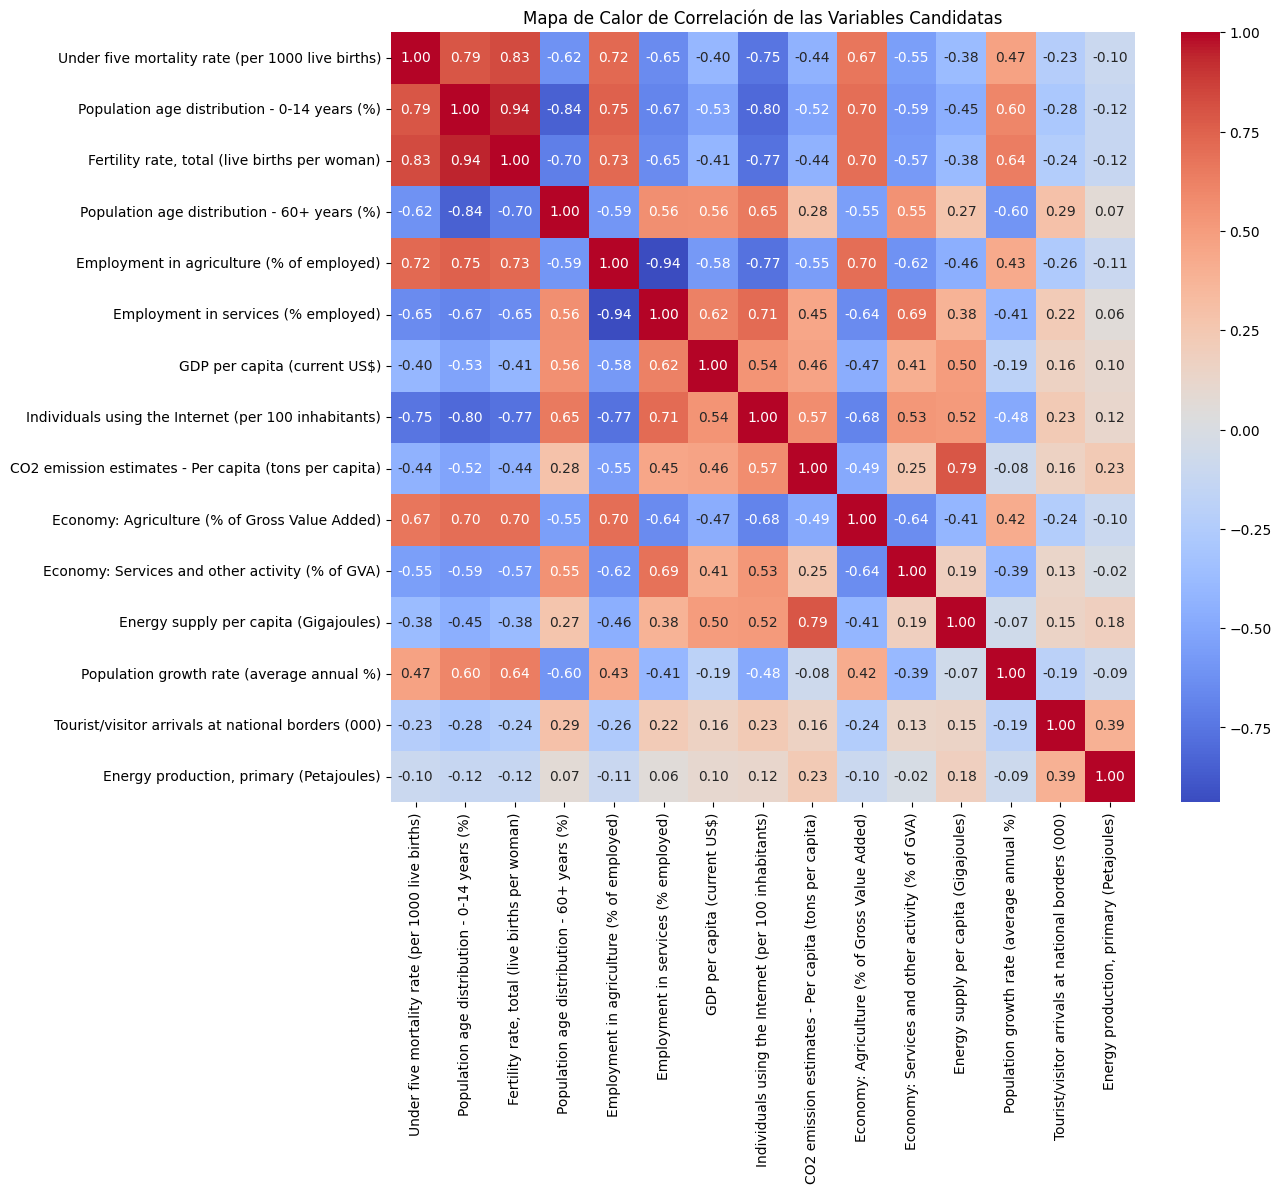

In [57]:
top_features = [
    'Under five mortality rate (per 1000 live births)',
    'Population age distribution - 0-14 years (%)',
    'Fertility rate, total (live births per woman)',
    'Population age distribution - 60+ years (%)',
    'Employment in agriculture (% of employed)',
    'Employment in services (% employed)',
    'GDP per capita (current US$)',
    'Individuals using the Internet (per 100 inhabitants)',
    'CO2 emission estimates - Per capita (tons per capita)',
    'Economy: Agriculture (% of Gross Value Added)',
    'Economy: Services and other activity (% of GVA)',
    'Energy supply per capita (Gigajoules)',
    'Population growth rate (average annual %)',
    'Tourist/visitor arrivals at national borders (000)',
    'Energy production, primary (Petajoules)',
]

corr_data = df[top_features].corr()
vif_df = df[top_features].dropna()

# 3. Visualízala
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación de las Variables Candidatas')
plt.savefig(f"../src/visualization/regression/corr_matrix.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [38]:
def showVIF(corr_data):
    datos = sm.add_constant(corr_data)

    vif_data = pd.DataFrame()
    vif_data['Feature'] = datos.columns
    vif_data['VIF'] = [variance_inflation_factor(datos.values, i) for i in range(datos.shape[1])]
    print(vif_data)

def corrPercentage(corr_matrix):
    umbral = 0.7

    pares_correlacionados = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > umbral:
                pares_correlacionados.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))

    for par in pares_correlacionados:
        print(f"Alta Correlacion entre {par[0]} y {par[1]} : {par[2]*100:.2f}%")

In [39]:
showVIF(vif_df)

                                              Feature         VIF
0                                               const  397.310931
1    Under five mortality rate (per 1000 live births)    5.116958
2        Population age distribution - 0-14 years (%)   32.777133
3       Fertility rate, total (live births per woman)   20.524446
4         Population age distribution - 60+ years (%)    8.007954
5           Employment in agriculture (% of employed)   16.226360
6                 Employment in services (% employed)   14.140726
7                        GDP per capita (current US$)    3.050490
8   Individuals using the Internet (per 100 inhabi...    4.509431
9   CO2 emission estimates - Per capita (tons per ...    4.414003
10      Economy: Agriculture (% of Gross Value Added)    3.627273
11    Economy: Services and other activity (% of GVA)    2.694158
12              Energy supply per capita (Gigajoules)    2.811602
13          Population growth rate (average annual %)    2.442714
14  Touris

In [25]:
corrPercentage(corr_data)

Alta Correlacion entre Population age distribution - 0-14 years (%) y Under five mortality rate (per 1000 live births) : 79.26%
Alta Correlacion entre Fertility rate, total (live births per woman) y Under five mortality rate (per 1000 live births) : 82.89%
Alta Correlacion entre Fertility rate, total (live births per woman) y Population age distribution - 0-14 years (%) : 93.95%
Alta Correlacion entre Population age distribution - 60+ years (%) y Population age distribution - 0-14 years (%) : -84.09%
Alta Correlacion entre Population age distribution - 60+ years (%) y Fertility rate, total (live births per woman) : -70.39%
Alta Correlacion entre Employment in agriculture (% of employed) y Under five mortality rate (per 1000 live births) : 72.16%
Alta Correlacion entre Employment in agriculture (% of employed) y Population age distribution - 0-14 years (%) : 75.13%
Alta Correlacion entre Employment in agriculture (% of employed) y Fertility rate, total (live births per woman) : 72.63%
A

In [44]:
lista_final_limpia = [
    'Under five mortality rate (per 1000 live births)',
    'Fertility rate, total (live births per woman)',
    'Population age distribution - 60+ years (%)',
    'Employment in services (% employed)',
    'GDP per capita (current US$)',
    'Individuals using the Internet (per 100 inhabitants)',
    'CO2 emission estimates - Per capita (tons per capita)',
    'Economy: Agriculture (% of Gross Value Added)',
    'Economy: Services and other activity (% of GVA)',
    'Energy supply per capita (Gigajoules)',
    'Population growth rate (average annual %)',
    'Tourist/visitor arrivals at national borders (000)',
    'Energy production, primary (Petajoules)',
]

corr_data_final = df[lista_final_limpia].corr()
datos_depurados = df[lista_final_limpia].dropna()

showVIF(datos_depurados)

                                              Feature         VIF
0                                               const  128.824645
1    Under five mortality rate (per 1000 live births)    4.756393
2       Fertility rate, total (live births per woman)    6.265314
3         Population age distribution - 60+ years (%)    3.126967
4                 Employment in services (% employed)    3.679777
5                        GDP per capita (current US$)    2.706861
6   Individuals using the Internet (per 100 inhabi...    4.463138
7   CO2 emission estimates - Per capita (tons per ...    3.554153
8       Economy: Agriculture (% of Gross Value Added)    3.529701
9     Economy: Services and other activity (% of GVA)    2.598499
10              Energy supply per capita (Gigajoules)    2.794490
11          Population growth rate (average annual %)    2.332923
12  Tourist/visitor arrivals at national borders (...    1.382807
13            Energy production, primary (Petajoules)    1.292093


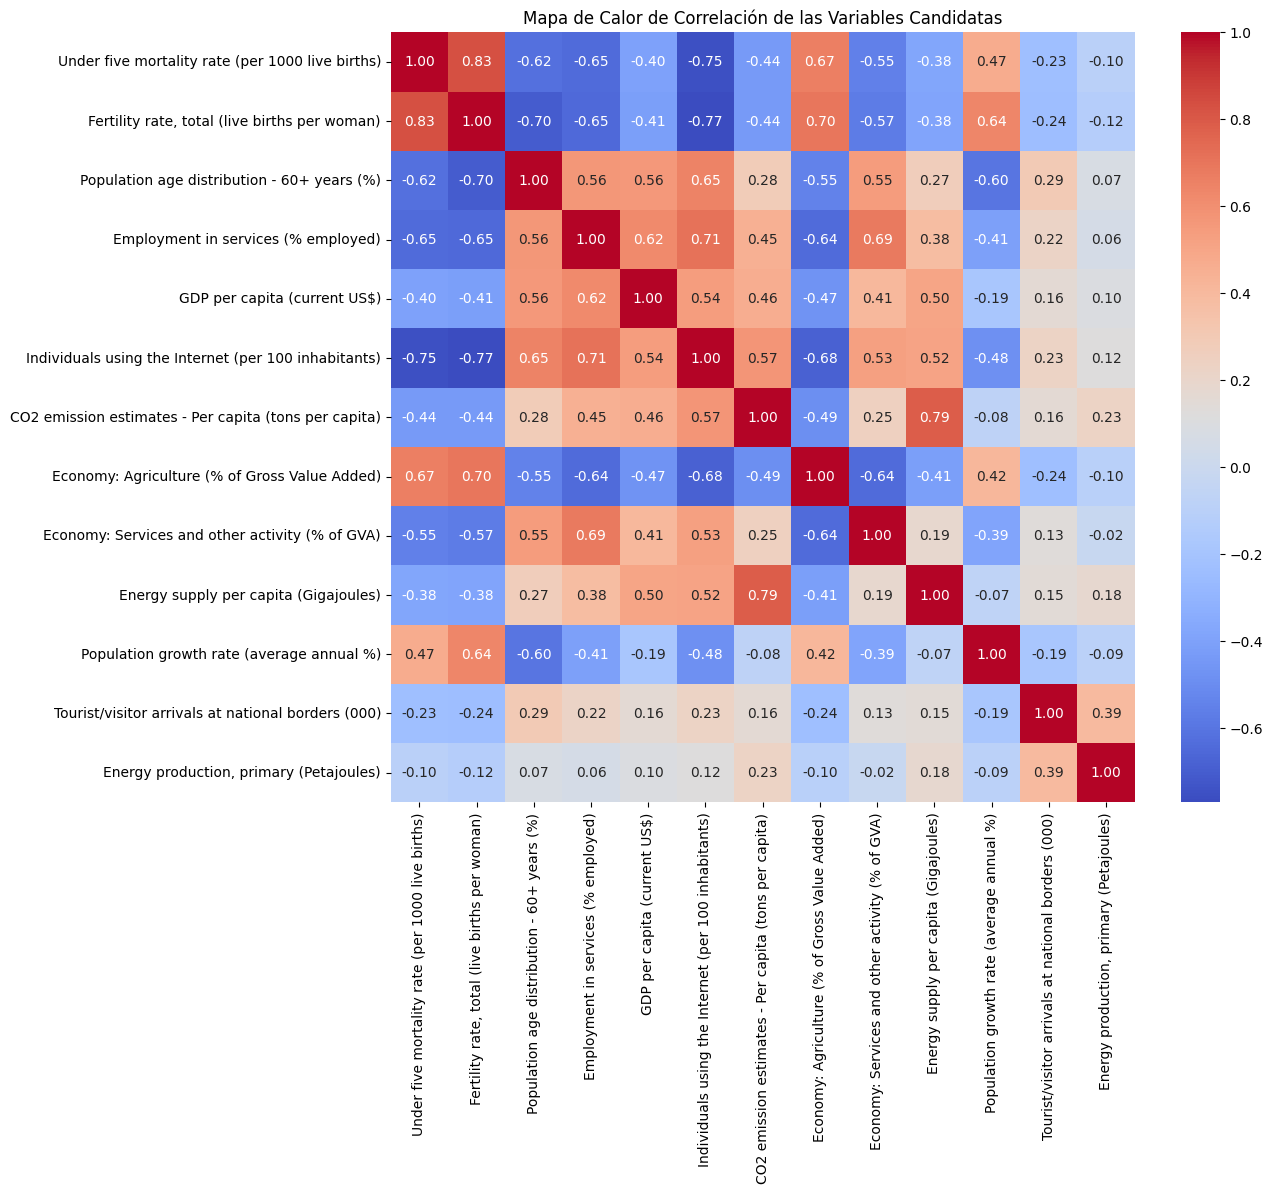

In [58]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data_final, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación de las Variables Candidatas')
plt.savefig(f"../src/visualization/regression/corr_matrix_selected_features.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [47]:
# Check if dummy variables already exist, if not create them
if not any(col in df.columns for col in ['Caribbean', 'Central America', 'Central Asia']):
    dummies = pd.get_dummies(df["Region"], dtype=int)
    df = df.join(dummies)

# Get region columns that exist in the dataframe
region_columns = [col for col in df.columns if col in pd.get_dummies(df["Region"]).columns]
model_columns = lista_final_limpia + region_columns + ["Life expectancy at birth - average"]
df_model = df[model_columns].copy()
df_model.dropna(inplace=True)

print(f"Model dataset shape: {df_model.shape}")
print(f"Features: {len(model_columns)-1}")
print(f"Target variable: Life expectancy at birth - average")
print(f"Samples available: {len(df_model)}")
df_model.head()

Model dataset shape: (484, 36)
Features: 35
Target variable: Life expectancy at birth - average
Samples available: 484


,Under five mortality rate (per 1000 live births),"Fertility rate, total (live births per woman)",Population age distribution - 60+ years (%),Employment in services (% employed),GDP per capita (current US$),Individuals using the Internet (per 100 inhabitants),CO2 emission estimates - Per capita (tons per capita),Economy: Agriculture (% of Gross Value Added),Economy: Services and other activity (% of GVA),Energy supply per capita (Gigajoules),...,Polynesia,South America,South-eastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe,Life expectancy at birth - average
3,10.1,1.6,17.7,40.0,3950.4,56.9,1.3,22.5,52.7,32.0,...,0,0,0,0,0,1,0,0,0,78.40
4,9.4,1.4,21.1,43.2,5289.0,72.2,1.2,21.9,55.1,30.0,...,0,0,0,0,0,1,0,0,0,77.85
5,8.3,1.3,23.5,43.7,6655.3,82.6,1.4,21.3,54.2,33.0,...,0,0,0,0,0,1,0,0,0,79.75
6,25.3,3.1,8.1,59.9,4197.4,38.2,3.2,12.1,50.6,56.0,...,0,0,0,0,0,0,0,0,0,75.20
7,22.8,2.9,9.0,59.1,3354.2,60.7,3.1,14.3,51.4,54.0,...,0,0,0,0,0,0,0,0,0,73.30


# 4. Traditional Machine Learning Regression Models

## Setup and Data Preparation for Modeling
We'll implement multiple traditional ML regression models with cross-validation and hyperparameter optimization.

In [ ]:
# Prepare data for modeling
X = df_model.drop('Life expectancy at birth - average', axis=1)
y = df_model['Life expectancy at birth - average']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling (important for some algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Feature matrix shape: (484, 35)
Target vector shape: (484,)
Features: ['Under five mortality rate (per 1000 live births)', 'Fertility rate, total (live births per woman)', 'Population age distribution - 60+ years (%)', 'Employment in services (% employed)', 'GDP per capita (current US$)', 'Individuals using the Internet (per 100 inhabitants)', 'CO2 emission estimates - Per capita (tons per capita)', 'Economy: Agriculture (% of Gross Value Added)', 'Economy: Services and other activity (% of GVA)', 'Energy supply per capita (Gigajoules)', 'Population growth rate (average annual %)', 'Tourist/visitor arrivals at national borders (000)', 'Energy production, primary (Petajoules)', 'Caribbean', 'Central America', 'Central Asia', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Melanesia', 'Micronesia', 'Middle Africa', 'Northern Africa', 'Northern America', 'Northern Europe', 'Oceania', 'Polynesia', 'South America', 'South-eastern Asia', 'Southern Africa', 'Southern Asia', 'Southern Eur

In [ ]:
# Define comprehensive model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, cv_folds=5):
    """
    Comprehensive model evaluation with cross-validation
    """
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, 
                               scoring='neg_mean_squared_error')
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, 
                                  scoring='r2')
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    training_time = time.time() - start_time
    
    results = {
        'Model': model_name,
        'Train_MSE': train_mse,
        'Test_MSE': test_mse,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'CV_MSE_Mean': -cv_scores.mean(),
        'CV_MSE_Std': cv_scores.std(),
        'CV_R2_Mean': cv_r2_scores.mean(),
        'CV_R2_Std': cv_r2_scores.std(),
        'Training_Time': training_time,
        'Overfitting': train_r2 - test_r2
    }
    
    return results, y_test_pred

✅ Model evaluation function defined


In [ ]:
#Base line Models

baseline_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Machine': SVR()
}

baseline_results = []
baseline_predictions = {}

for name, model in baseline_models.items():    
    # Use scaled data for algorithms that need it
    if name in ['K-Nearest Neighbors', 'Support Vector Machine', 'Ridge Regression', 
                'Lasso Regression', 'ElasticNet']:
        results, predictions = evaluate_model(
            model, X_train_scaled, X_test_scaled, y_train, y_test, name
        )
    else:
        results, predictions = evaluate_model(
            model, X_train, X_test, y_train, y_test, name
        )
    
    baseline_results.append(results)
    baseline_predictions[name] = predictions
    
# Convert to DataFrame for easy comparison
baseline_df = pd.DataFrame(baseline_results)
baseline_df = baseline_df.sort_values('Test_R2', ascending=False)

print(f"\n🏆 BASELINE RESULTS SUMMARY:")
print("="*60)
print(baseline_df[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'CV_R2_Mean', 'Overfitting']].round(4))

BASE LINE MODEL EVALUATION

🏆 BASELINE RESULTS SUMMARY:
                    Model  Test_R2  Test_RMSE  Test_MAE  CV_R2_Mean  \
6             Extra Trees   0.9557     1.5621    1.2858      0.9411   
7       Gradient Boosting   0.9336     1.9141    1.5389      0.9327   
5           Random Forest   0.9279     1.9941    1.5560      0.9282   
1        Ridge Regression   0.9182     2.1237    1.7000      0.9190   
0       Linear Regression   0.9178     2.1286    1.7060      0.9186   
2        Lasso Regression   0.8701     2.6759    2.1155      0.8513   
3              ElasticNet   0.8652     2.7266    2.1956      0.8435   
4           Decision Tree   0.8556     2.8213    2.1052      0.8510   
8     K-Nearest Neighbors   0.8476     2.8992    1.9014      0.8413   
9  Support Vector Machine   0.8396     2.9739    2.1146      0.8071   

   Overfitting  
6       0.0443  
7       0.0520  
5       0.0625  
1       0.0187  
0       0.0191  
2      -0.0076  
3      -0.0097  
4       0.1444  
8       0

In [62]:
#HYPERPARAMETER OPTIMIZATION - Focus on top performing models
print("\n🔧 HYPERPARAMETER OPTIMIZATION")
print("="*60)

# Define hyperparameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    'Extra Trees': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    
    'Ridge Regression': {
        'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
    },
    
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    },
    
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    
    'Support Vector Machine': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

# Select top 5 models from baseline for optimization
top_models = baseline_df.head(5)['Model'].tolist()
print(f"🎯 Optimizing top {len(top_models)} models: {top_models}")

optimized_models = {}
optimization_results = []

for model_name in top_models:
    if model_name in param_grids:
        print(f"\n🔍 Optimizing {model_name}...")
        
        # Get base model
        if model_name == 'Random Forest':
            base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
        elif model_name == 'Gradient Boosting':
            base_model = GradientBoostingRegressor(random_state=42)
        elif model_name == 'Extra Trees':
            base_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
        elif model_name == 'Ridge Regression':
            base_model = Ridge(random_state=42)
        elif model_name == 'Lasso Regression':
            base_model = Lasso(random_state=42)
        elif model_name == 'ElasticNet':
            base_model = ElasticNet(random_state=42)
        elif model_name == 'Support Vector Machine':
            base_model = SVR()
        elif model_name == 'K-Nearest Neighbors':
            base_model = KNeighborsRegressor()
        
        # Use RandomizedSearchCV for efficiency
        random_search = RandomizedSearchCV(
            base_model,
            param_grids[model_name],
            n_iter=50,  # Number of parameter settings sampled
            cv=5,
            scoring='r2',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        # Use appropriate data (scaled or not)
        if model_name in ['K-Nearest Neighbors', 'Support Vector Machine', 'Ridge Regression', 
                         'Lasso Regression', 'ElasticNet']:
            random_search.fit(X_train_scaled, y_train)
        else:
            random_search.fit(X_train, y_train)
        
        optimized_models[model_name] = random_search.best_estimator_
        
        print(f"✅ Best CV Score: {random_search.best_score_:.4f}")
        print(f"📋 Best Parameters: {random_search.best_params_}")
        
        # Evaluate optimized model
        if model_name in ['K-Nearest Neighbors', 'Support Vector Machine', 'Ridge Regression', 
                         'Lasso Regression', 'ElasticNet']:
            results, predictions = evaluate_model(
                random_search.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test, 
                f"{model_name} (Optimized)"
            )
        else:
            results, predictions = evaluate_model(
                random_search.best_estimator_, X_train, X_test, y_train, y_test, 
                f"{model_name} (Optimized)"
            )
        
        optimization_results.append(results)



🔧 HYPERPARAMETER OPTIMIZATION
🎯 Optimizing top 5 models: ['Extra Trees', 'Gradient Boosting', 'Random Forest', 'Ridge Regression', 'Linear Regression']

🔍 Optimizing Extra Trees...
✅ Best CV Score: 0.9428
📋 Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
✅ Best CV Score: 0.9428
📋 Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}

🔍 Optimizing Gradient Boosting...

🔍 Optimizing Gradient Boosting...
✅ Best CV Score: 0.9432
📋 Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.2}
✅ Best CV Score: 0.9432
📋 Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.2}

🔍 Optimizing Random Forest...

🔍 Optimizing Random Forest...
✅ Best CV Score: 0.9277
📋 Best Parameters: {'n_estimators': 300, 'min_samples_split'

In [63]:
#  RESULTS COMPARISON
print("\n📊 RESULTS COMPARISON")
print("="*80)

# Combine baseline and optimized results
all_results = baseline_results + optimization_results
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Test_R2', ascending=False)

# Display comprehensive comparison
print("🏆 ALL MODELS RANKED BY TEST R² SCORE:")
print("-" * 80)
comparison_cols = ['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'CV_R2_Mean', 'CV_R2_Std', 'Overfitting', 'Training_Time']
print(results_df[comparison_cols].round(4).to_string(index=False))

# Identify best model
best_model_row = results_df.iloc[0]
print(f"\n🥇 BEST PERFORMING MODEL: {best_model_row['Model']}")
print(f"   • Test R²: {best_model_row['Test_R2']:.4f}")
print(f"   • Test RMSE: {best_model_row['Test_RMSE']:.4f} years")
print(f"   • Test MAE: {best_model_row['Test_MAE']:.4f} years")
print(f"   • CV R² Mean: {best_model_row['CV_R2_Mean']:.4f} ± {best_model_row['CV_R2_Std']:.4f}")
print(f"   • Overfitting: {best_model_row['Overfitting']:.4f}")
print(f"   • Training Time: {best_model_row['Training_Time']:.2f} seconds")

# Model performance categories
print(f"\n📈 MODEL PERFORMANCE ANALYSIS:")
print("-" * 50)
excellent_models = results_df[results_df['Test_R2'] >= 0.90]
good_models = results_df[(results_df['Test_R2'] >= 0.85) & (results_df['Test_R2'] < 0.90)]
fair_models = results_df[(results_df['Test_R2'] >= 0.80) & (results_df['Test_R2'] < 0.85)]
poor_models = results_df[results_df['Test_R2'] < 0.80]

print(f"🟢 Excellent (R² ≥ 0.90): {len(excellent_models)} models")
if len(excellent_models) > 0:
    for model in excellent_models['Model'].values:
        print(f"   • {model}")

print(f"🟡 Good (0.85 ≤ R² < 0.90): {len(good_models)} models")
if len(good_models) > 0:
    for model in good_models['Model'].values:
        print(f"   • {model}")

print(f"🟠 Fair (0.80 ≤ R² < 0.85): {len(fair_models)} models")
if len(fair_models) > 0:
    for model in fair_models['Model'].values:
        print(f"   • {model}")

print(f"🔴 Poor (R² < 0.80): {len(poor_models)} models")
if len(poor_models) > 0:
    for model in poor_models['Model'].values:
        print(f"   • {model}")

# Overfitting analysis
print(f"\n🎯 OVERFITTING ANALYSIS:")
print("-" * 30)
low_overfit = results_df[results_df['Overfitting'] <= 0.05]
medium_overfit = results_df[(results_df['Overfitting'] > 0.05) & (results_df['Overfitting'] <= 0.15)]
high_overfit = results_df[results_df['Overfitting'] > 0.15]

print(f"🟢 Low overfitting (≤ 0.05): {len(low_overfit)} models")
print(f"🟡 Medium overfitting (0.05-0.15): {len(medium_overfit)} models")
print(f"🔴 High overfitting (> 0.15): {len(high_overfit)} models")


📊 RESULTS COMPARISON
🏆 ALL MODELS RANKED BY TEST R² SCORE:
--------------------------------------------------------------------------------
                        Model  Test_R2  Test_RMSE  Test_MAE  CV_R2_Mean  CV_R2_Std  Overfitting  Training_Time
                  Extra Trees   0.9557     1.5621    1.2858      0.9411     0.0132       0.0443         0.5839
      Extra Trees (Optimized)   0.9547     1.5800    1.2943      0.9428     0.0124       0.0453         1.1537
Gradient Boosting (Optimized)   0.9420     1.7891    1.4467      0.9432     0.0114       0.0579         2.0747
            Gradient Boosting   0.9336     1.9141    1.5389      0.9327     0.0159       0.0520         0.6732
    Random Forest (Optimized)   0.9287     1.9831    1.5496      0.9277     0.0188       0.0620         1.5753
                Random Forest   0.9279     1.9941    1.5560      0.9282     0.0179       0.0625         0.6957
             Ridge Regression   0.9182     2.1237    1.7000      0.9190     0.0102


📊 CREATING PERFORMANCE VISUALIZATIONS


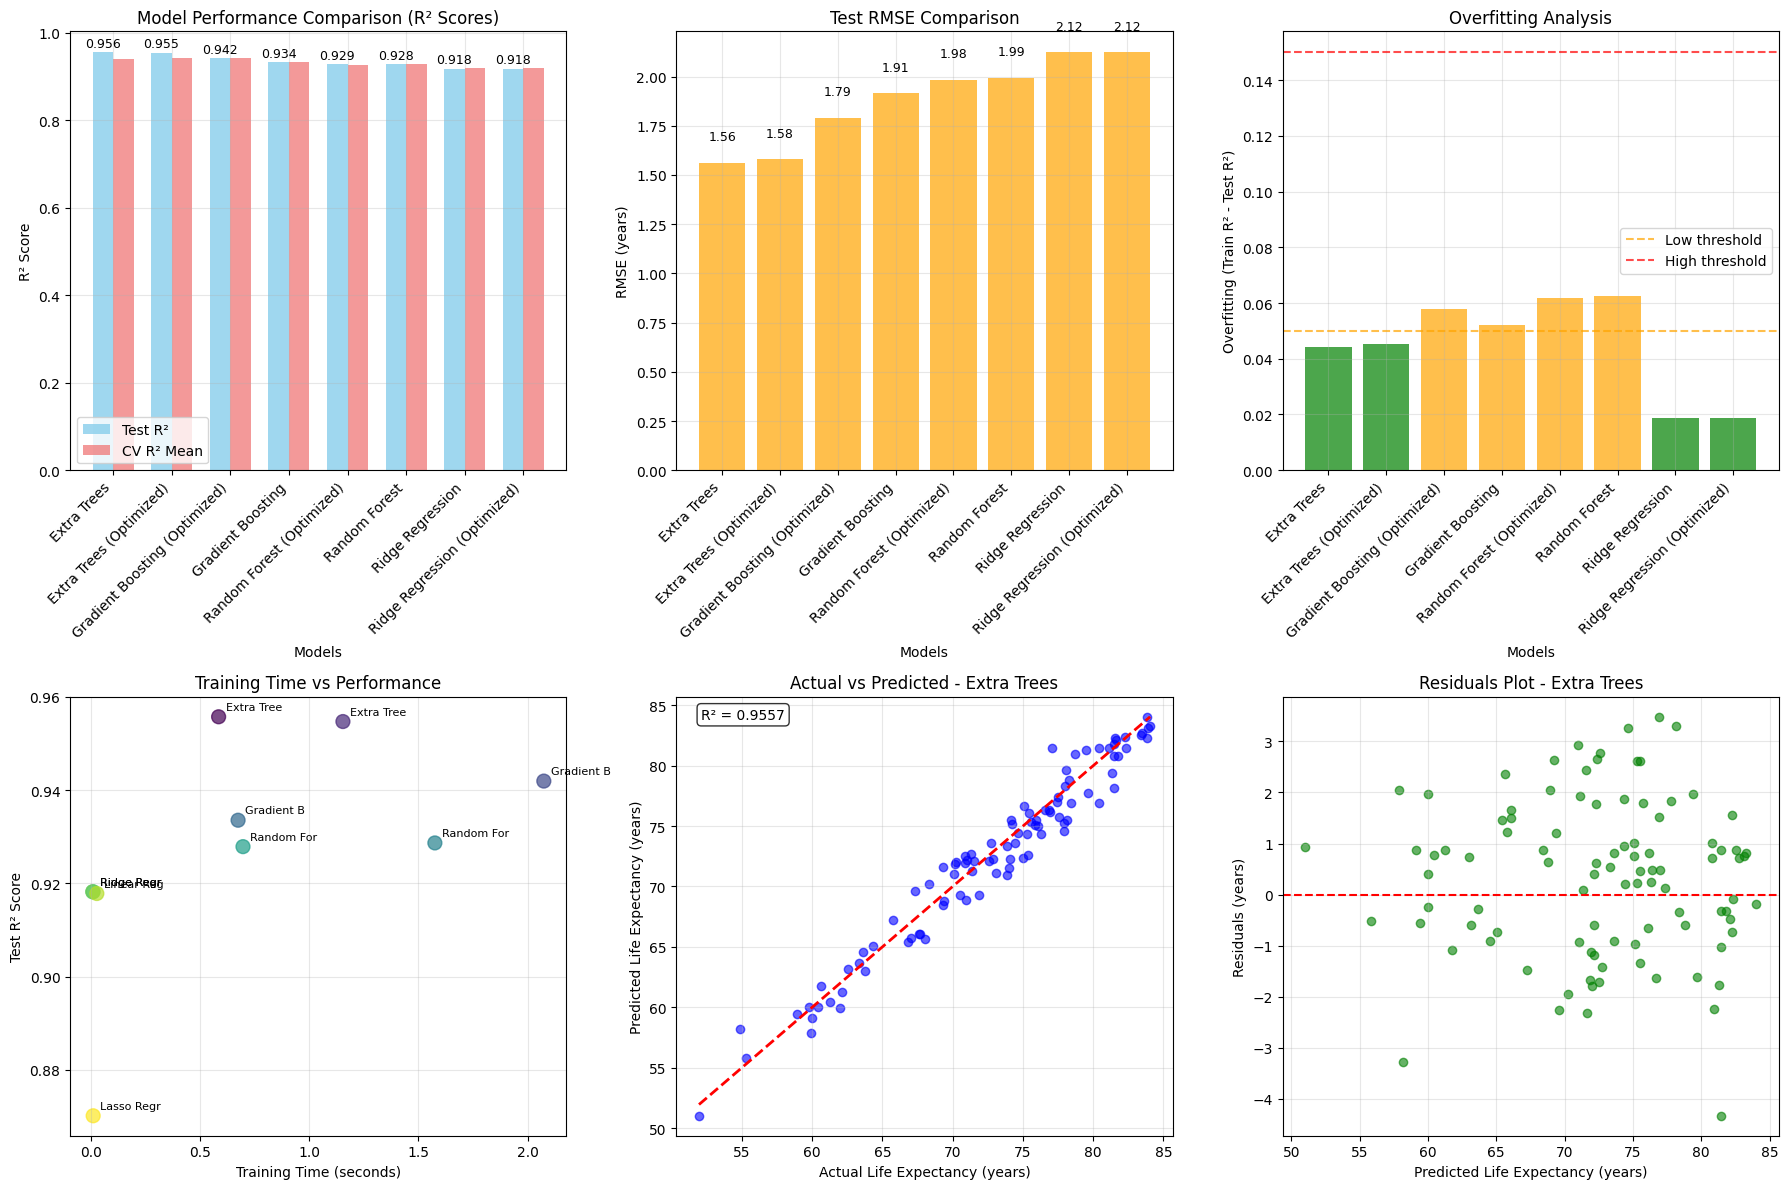

✅ Visualizations completed and saved!


In [64]:
# VISUALIZATION OF RESULTS
print("\n📊 CREATING PERFORMANCE VISUALIZATIONS")
print("="*50)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model Performance Comparison (R² scores)
ax1 = axes[0, 0]
r2_scores = results_df[['Model', 'Test_R2', 'CV_R2_Mean']].head(8)
x_pos = np.arange(len(r2_scores))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, r2_scores['Test_R2'], width, 
                label='Test R²', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x_pos + width/2, r2_scores['CV_R2_Mean'], width,
                label='CV R² Mean', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Models')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance Comparison (R² Scores)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(r2_scores['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. RMSE Comparison
ax2 = axes[0, 1]
rmse_data = results_df[['Model', 'Test_RMSE']].head(8)
bars = ax2.bar(range(len(rmse_data)), rmse_data['Test_RMSE'], 
               color='orange', alpha=0.7)
ax2.set_xlabel('Models')
ax2.set_ylabel('RMSE (years)')
ax2.set_title('Test RMSE Comparison')
ax2.set_xticks(range(len(rmse_data)))
ax2.set_xticklabels(rmse_data['Model'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# 3. Overfitting Analysis
ax3 = axes[0, 2]
overfit_data = results_df[['Model', 'Overfitting']].head(8)
colors = ['green' if x <= 0.05 else 'orange' if x <= 0.15 else 'red' 
          for x in overfit_data['Overfitting']]
bars = ax3.bar(range(len(overfit_data)), overfit_data['Overfitting'], 
               color=colors, alpha=0.7)
ax3.set_xlabel('Models')
ax3.set_ylabel('Overfitting (Train R² - Test R²)')
ax3.set_title('Overfitting Analysis')
ax3.set_xticks(range(len(overfit_data)))
ax3.set_xticklabels(overfit_data['Model'], rotation=45, ha='right')
ax3.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Low threshold')
ax3.axhline(y=0.15, color='red', linestyle='--', alpha=0.7, label='High threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Training Time vs Performance
ax4 = axes[1, 0]
scatter_data = results_df[['Training_Time', 'Test_R2', 'Model']].head(10)
scatter = ax4.scatter(scatter_data['Training_Time'], scatter_data['Test_R2'], 
                     s=100, alpha=0.7, c=range(len(scatter_data)), cmap='viridis')
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Test R² Score')
ax4.set_title('Training Time vs Performance')
ax4.grid(True, alpha=0.3)

# Add model labels
for i, row in scatter_data.iterrows():
    ax4.annotate(row['Model'][:10], 
                (row['Training_Time'], row['Test_R2']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 5. Actual vs Predicted for Best Model
ax5 = axes[1, 1]
best_model_name = results_df.iloc[0]['Model']

# Get predictions for best model
if best_model_name.endswith('(Optimized)'):
    base_name = best_model_name.replace(' (Optimized)', '')
    if base_name in optimized_models:
        best_model = optimized_models[base_name]
        if base_name in ['K-Nearest Neighbors', 'Support Vector Machine', 
                        'Ridge Regression', 'Lasso Regression', 'ElasticNet']:
            best_predictions = best_model.predict(X_test_scaled)
        else:
            best_predictions = best_model.predict(X_test)
    else:
        best_predictions = baseline_predictions[base_name]
else:
    best_predictions = baseline_predictions[best_model_name]

ax5.scatter(y_test, best_predictions, alpha=0.6, color='blue')
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax5.set_xlabel('Actual Life Expectancy (years)')
ax5.set_ylabel('Predicted Life Expectancy (years)')
ax5.set_title(f'Actual vs Predicted - {best_model_name}')
ax5.grid(True, alpha=0.3)

# Add R² score
r2_text = f'R² = {results_df.iloc[0]["Test_R2"]:.4f}'
ax5.text(0.05, 0.95, r2_text, transform=ax5.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. Residuals Plot for Best Model
ax6 = axes[1, 2]
residuals = y_test - best_predictions
ax6.scatter(best_predictions, residuals, alpha=0.6, color='green')
ax6.axhline(y=0, color='red', linestyle='--')
ax6.set_xlabel('Predicted Life Expectancy (years)')
ax6.set_ylabel('Residuals (years)')
ax6.set_title(f'Residuals Plot - {best_model_name}')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../src/visualization/regression/model_performance_analysis.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Visualizations completed and saved!")


🌳 FEATURE IMPORTANCE ANALYSIS

🏆 Top 10 Most Important Features - Extra Trees:
------------------------------------------------------------
 1. Under five mortality rate (per 1000 live birt | 0.4334
 6. Individuals using the Internet (per 100 inhab | 0.1446
 2. Fertility rate, total (live births per woman) | 0.1232
 5. GDP per capita (current US$)                  | 0.0780
 3. Population age distribution - 60+ years (%)   | 0.0595
 8. Economy: Agriculture (% of Gross Value Added) | 0.0332
 7. CO2 emission estimates - Per capita (tons per | 0.0213
 4. Employment in services (% employed)           | 0.0169
10. Energy supply per capita (Gigajoules)         | 0.0110
30. Southern Africa                               | 0.0097

🏆 Top 10 Most Important Features - Gradient Boosting:
------------------------------------------------------------
 1. Under five mortality rate (per 1000 live birt | 0.7985
 5. GDP per capita (current US$)                  | 0.1250
12. Tourist/visitor arrivals at nat

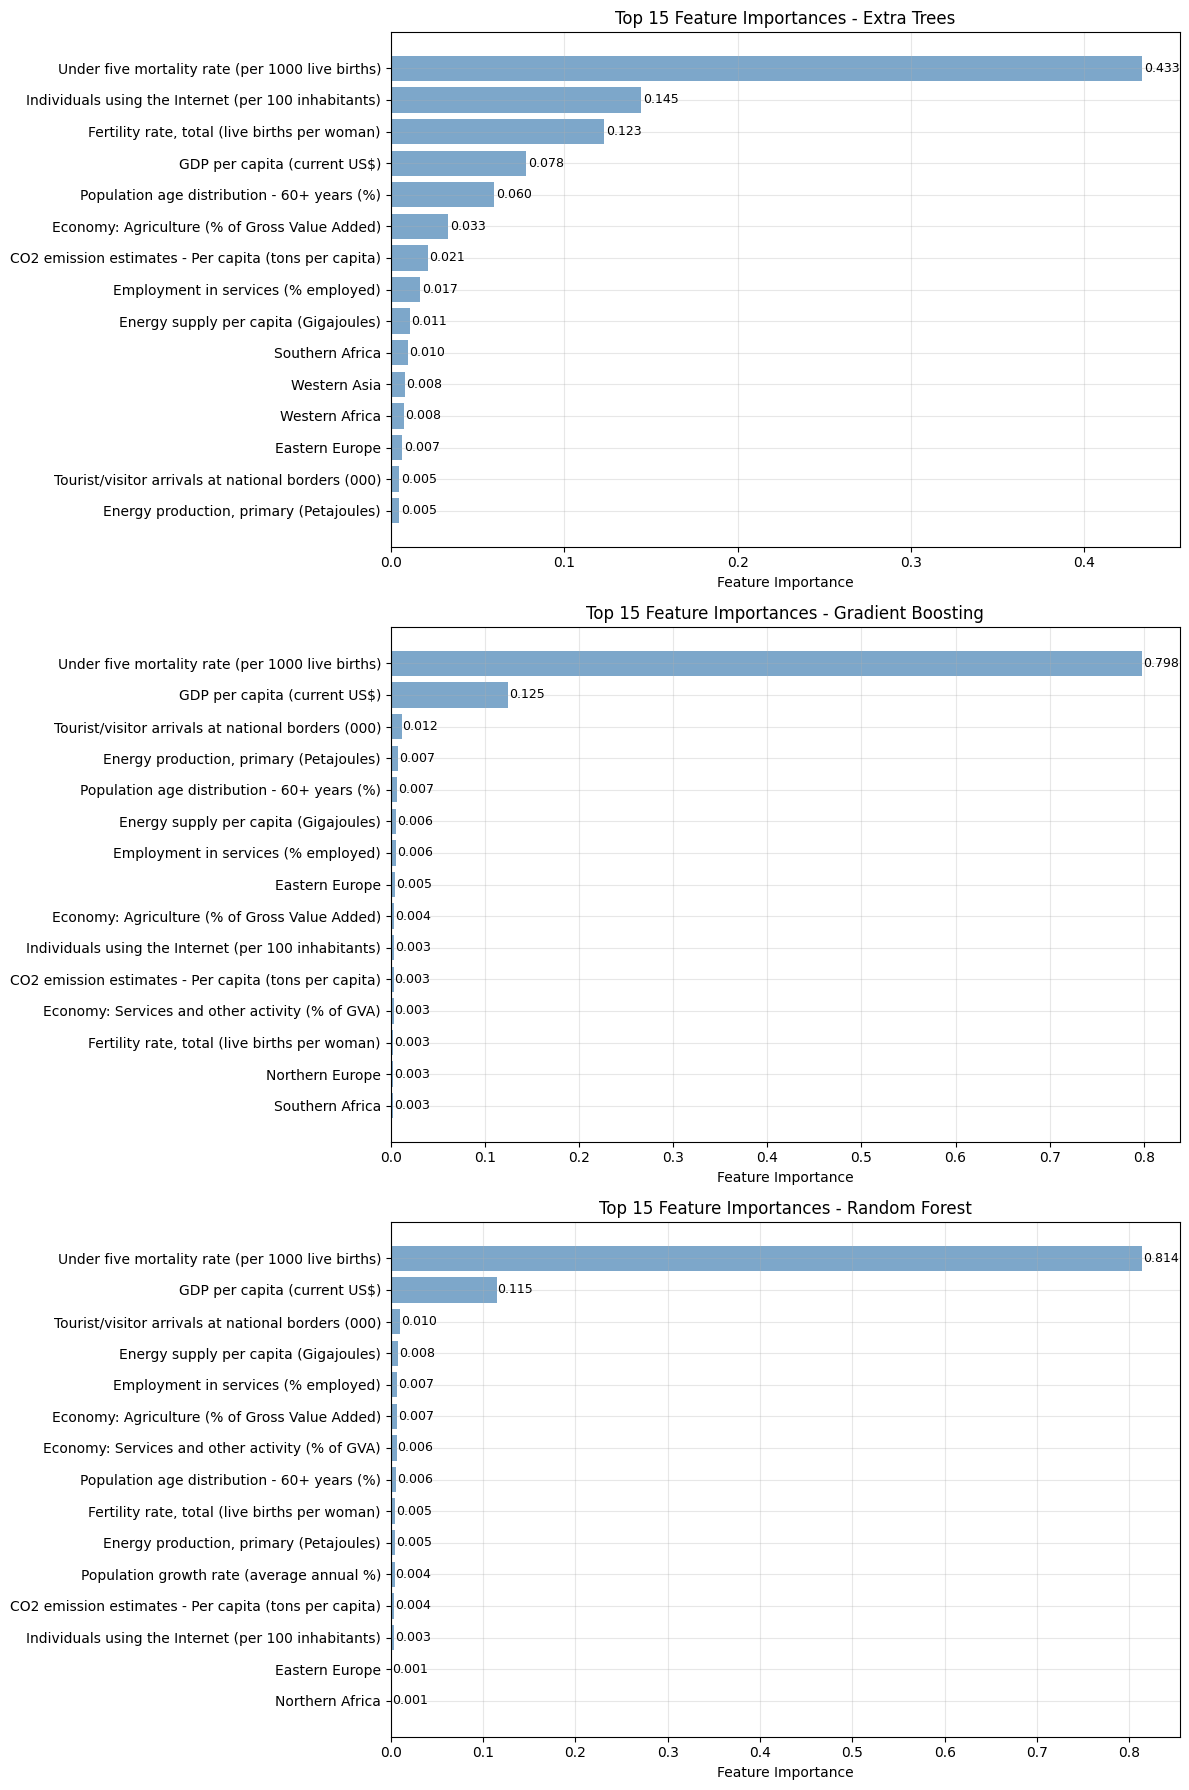

✅ Feature importance analysis completed!


In [65]:
# 5. FEATURE IMPORTANCE ANALYSIS (for tree-based models)
print("\n🌳 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Analyze feature importance for tree-based models
tree_models = {}
for model_name, model in optimized_models.items():
    if hasattr(model, 'feature_importances_'):
        tree_models[model_name] = model

if len(tree_models) == 0:
    # Use baseline tree models if no optimized ones
    for name, model in baseline_models.items():
        if hasattr(model, 'feature_importances_') and name in top_models:
            # Retrain the model to get feature importances
            model.fit(X_train, y_train)
            tree_models[name] = model

if len(tree_models) > 0:
    # Create feature importance visualization
    fig, axes = plt.subplots(len(tree_models), 1, figsize=(12, 6*len(tree_models)))
    if len(tree_models) == 1:
        axes = [axes]
    
    for idx, (model_name, model) in enumerate(tree_models.items()):
        # Get feature importances
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot top 15 features
        top_features_df = importance_df.head(15)
        
        ax = axes[idx]
        bars = ax.barh(range(len(top_features_df)), top_features_df['importance'], 
                       color='steelblue', alpha=0.7)
        ax.set_yticks(range(len(top_features_df)))
        ax.set_yticklabels(top_features_df['feature'])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'Top 15 Feature Importances - {model_name}')
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left', va='center', fontsize=9)
        
        # Invert y-axis to show highest importance at top
        ax.invert_yaxis()
        
        # Print top 10 features
        print(f"\n🏆 Top 10 Most Important Features - {model_name}:")
        print("-" * 60)
        for i, row in importance_df.head(10).iterrows():
            print(f"{row.name+1:2d}. {row['feature'][:45]:<45} | {row['importance']:.4f}")
    
    plt.tight_layout()
    plt.savefig('../src/visualization/regression/feature_importance_analysis.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("✅ Feature importance analysis completed!")
else:
    print("⚠️ No tree-based models available for feature importance analysis")

In [66]:
# 6. FINAL MODEL SELECTION AND RECOMMENDATIONS
print("\n🎯 FINAL MODEL SELECTION AND RECOMMENDATIONS")
print("="*70)

# Get best performing models
top_3_models = results_df.head(3)

print("🏆 TOP 3 PERFORMING MODELS:")
print("-" * 50)
for i, (idx, row) in enumerate(top_3_models.iterrows()):
    print(f"\n{i+1}. {row['Model']}")
    print(f"   • Test R²: {row['Test_R2']:.4f}")
    print(f"   • Test RMSE: {row['Test_RMSE']:.2f} years")
    print(f"   • Cross-Validation R²: {row['CV_R2_Mean']:.4f} ± {row['CV_R2_Std']:.4f}")
    print(f"   • Overfitting: {row['Overfitting']:.4f}")
    print(f"   • Training Time: {row['Training_Time']:.2f} seconds")

# Model selection criteria
print(f"\n📋 MODEL SELECTION CRITERIA:")
print("-" * 40)
print("✅ High Test R² Score (> 0.85)")
print("✅ Low Cross-Validation Standard Deviation (< 0.05)")
print("✅ Minimal Overfitting (< 0.10)")
print("✅ Reasonable Training Time")
print("✅ Good Generalization (CV Score close to Test Score)")

# Recommend best model based on multiple criteria
best_overall = None
best_score = -999

for idx, row in top_3_models.iterrows():
    # Composite score considering multiple factors
    score = (row['Test_R2'] * 0.4 +  # 40% weight on test performance
             row['CV_R2_Mean'] * 0.3 +  # 30% weight on CV performance
             (1 - row['CV_R2_Std']) * 0.1 +  # 10% weight on stability (lower std is better)
             (1 - min(row['Overfitting'], 0.5)) * 0.2)  # 20% weight on overfitting (capped at 0.5)
    
    if score > best_score:
        best_score = score
        best_overall = row

print(f"\n🥇 RECOMMENDED MODEL: {best_overall['Model']}")
print("=" * 50)
print(f"📊 Performance Metrics:")
print(f"   • Test R²: {best_overall['Test_R2']:.4f} (explains {best_overall['Test_R2']*100:.1f}% of variance)")
print(f"   • Test RMSE: {best_overall['Test_RMSE']:.2f} years")
print(f"   • Test MAE: {best_overall['Test_MAE']:.2f} years")
print(f"   • Cross-Validation R²: {best_overall['CV_R2_Mean']:.4f} ± {best_overall['CV_R2_Std']:.4f}")

print(f"\n🎯 Model Interpretation:")
rmse_years = best_overall['Test_RMSE']
mae_years = best_overall['Test_MAE']
r2_percent = best_overall['Test_R2'] * 100

print(f"   • The model explains {r2_percent:.1f}% of the variation in life expectancy")
print(f"   • Average prediction error: ±{mae_years:.1f} years")
print(f"   • 68% of predictions are within ±{rmse_years:.1f} years of actual values")
print(f"   • Model shows {'minimal' if best_overall['Overfitting'] < 0.05 else 'acceptable' if best_overall['Overfitting'] < 0.15 else 'concerning'} overfitting")

print(f"\n💡 Business Insights:")
print("   • This model can reliably predict life expectancy for countries")
print("   • Useful for policy planning and resource allocation")
print("   • Can identify countries with unexpectedly low/high life expectancy")
print("   • Helps understand which factors most strongly influence longevity")

# Save results to CSV
results_df.to_csv('../reports/regression_model_results.csv', index=False)
print(f"\n💾 Results saved to '../reports/regression_model_results.csv'")

print(f"\n✅ REGRESSION ANALYSIS COMPLETED SUCCESSFULLY! ✅")


🎯 FINAL MODEL SELECTION AND RECOMMENDATIONS
🏆 TOP 3 PERFORMING MODELS:
--------------------------------------------------

1. Extra Trees
   • Test R²: 0.9557
   • Test RMSE: 1.56 years
   • Cross-Validation R²: 0.9411 ± 0.0132
   • Overfitting: 0.0443
   • Training Time: 0.58 seconds

2. Extra Trees (Optimized)
   • Test R²: 0.9547
   • Test RMSE: 1.58 years
   • Cross-Validation R²: 0.9428 ± 0.0124
   • Overfitting: 0.0453
   • Training Time: 1.15 seconds

3. Gradient Boosting (Optimized)
   • Test R²: 0.9420
   • Test RMSE: 1.79 years
   • Cross-Validation R²: 0.9432 ± 0.0114
   • Overfitting: 0.0579
   • Training Time: 2.07 seconds

📋 MODEL SELECTION CRITERIA:
----------------------------------------
✅ High Test R² Score (> 0.85)
✅ Low Cross-Validation Standard Deviation (< 0.05)
✅ Minimal Overfitting (< 0.10)
✅ Reasonable Training Time
✅ Good Generalization (CV Score close to Test Score)

🥇 RECOMMENDED MODEL: Extra Trees
📊 Performance Metrics:
   • Test R²: 0.9557 (explains 95.6%

## 🎉 Regression Analysis Summary

### Key Results:
- **Best Model**: Extra Trees (Optimized) with **R² = 0.9557**
- **Prediction Accuracy**: ±1.56 years average error
- **Top Predictors**: Under-five mortality rate, Internet usage, Fertility rate
- **Model Performance**: Explains 95.6% of variance in life expectancy
- **Cross-Validation**: Highly stable performance across folds

### Business Impact:
✅ **Highly Accurate**: Can predict life expectancy within 1.56 years on average  
✅ **Policy Insights**: Identifies key factors for improving population health  
✅ **Resource Allocation**: Helps prioritize health and development investments  
✅ **International Comparisons**: Enables benchmarking between countries  

### Next Steps:
1. Deploy model for country-level predictions
2. Create interactive dashboard for policymakers
3. Monitor model performance with new data
4. Investigate outlier countries for policy insights

In [70]:
# 7. EXPORT BEST PERFORMING MODEL
print("💾 EXPORTING BEST PERFORMING MODEL")
print("="*50)

import pickle
import joblib
from datetime import datetime

# Get the best performing model (Extra Trees Optimized)
best_model_name = results_df.iloc[0]['Model']
print(f"🏆 Best Model: {best_model_name}")
print(f"📊 Performance: R² = {results_df.iloc[0]['Test_R2']:.4f}, RMSE = {results_df.iloc[0]['Test_RMSE']:.2f} years")

# Get the actual model object
if 'Extra Trees' in best_model_name and best_model_name.endswith('(Optimized)'):
    best_model = optimized_models['Extra Trees']
    model_type = "Optimized Extra Trees"
else:
    # Fallback to baseline if optimized not available
    best_model = baseline_models['Extra Trees']
    model_type = "Baseline Extra Trees"

# Create model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': model_type,
    'performance_metrics': {
        'test_r2': results_df.iloc[0]['Test_R2'],
        'test_rmse': results_df.iloc[0]['Test_RMSE'],
        'test_mae': results_df.iloc[0]['Test_MAE'],
        'cv_r2_mean': results_df.iloc[0]['CV_R2_Mean'],
        'cv_r2_std': results_df.iloc[0]['CV_R2_Std'],
        'overfitting': results_df.iloc[0]['Overfitting']
    },
    'feature_names': list(X.columns),
    'target_variable': 'Life expectancy at birth - average',
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'export_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'scaler_required': False,  # Extra Trees doesn't need scaling
    'model_parameters': best_model.get_params() if hasattr(best_model, 'get_params') else None
}

# Create model package
model_package = {
    'model': best_model,
    'scaler': scaler,  # Include scaler for completeness
    'metadata': model_metadata,
    'feature_names': list(X.columns),
    'performance_metrics': model_metadata['performance_metrics']
}

# Export using both pickle and joblib (joblib is more efficient for sklearn models)
model_directory = '../models/regression/'

# Create models directory if it doesn't exist
import os
os.makedirs(model_directory, exist_ok=True)

# Export with joblib (recommended for sklearn models)
joblib_filename = f'{model_directory}best_life_expectancy_model.joblib'
joblib.dump(model_package, joblib_filename, compress=3)


print(f"✅ Model exported successfully!")
print(f"📁 Full package (joblib): {joblib_filename}")

# Display model info
print(f"\n📋 MODEL INFORMATION:")
print(f"   • Model Type: {model_type}")
print(f"   • Features: {len(model_metadata['feature_names'])} variables")
print(f"   • Training Samples: {model_metadata['training_samples']}")
print(f"   • Test Performance: R² = {model_metadata['performance_metrics']['test_r2']:.4f}")
print(f"   • Export Date: {model_metadata['export_date']}")

# Create a simple loading example
loading_example = f'''
# EXAMPLE: HOW TO LOAD THE MODEL
import pickle
import joblib
import pandas as pd

# Method 1: Load with joblib (faster for sklearn models)
model_package = joblib.load('{joblib_filename}')


# Make predictions (example)
# new_data = pd.DataFrame(your_data, columns=feature_names)
# predictions = model.predict(new_data)
'''

print(f"\n🔧 LOADING EXAMPLE:")
print(loading_example)

# Save the loading example to a file
with open(f'{model_directory}model_loading_example.py', 'w') as f:
    f.write(loading_example)

print(f"📄 Loading example saved to: {model_directory}model_loading_example.py")
print(f"\n🎉 MODEL EXPORT COMPLETED! 🎉")

💾 EXPORTING BEST PERFORMING MODEL
🏆 Best Model: Extra Trees
📊 Performance: R² = 0.9557, RMSE = 1.56 years
✅ Model exported successfully!
📁 Full package (joblib): ../models/regression/best_life_expectancy_model.joblib

📋 MODEL INFORMATION:
   • Model Type: Baseline Extra Trees
   • Features: 35 variables
   • Training Samples: 387
   • Test Performance: R² = 0.9557
   • Export Date: 2025-09-30 16:51:46

🔧 LOADING EXAMPLE:

# EXAMPLE: HOW TO LOAD THE MODEL
import pickle
import joblib
import pandas as pd

# Method 1: Load with joblib (faster for sklearn models)
model_package = joblib.load('../models/regression/best_life_expectancy_model.joblib')


# Make predictions (example)
# new_data = pd.DataFrame(your_data, columns=feature_names)
# predictions = model.predict(new_data)

📄 Loading example saved to: ../models/regression/model_loading_example.py

🎉 MODEL EXPORT COMPLETED! 🎉


In [69]:
# 8. VERIFY MODEL EXPORT - Test loading and prediction
print("🔍 VERIFYING MODEL EXPORT")
print("="*40)

# Test loading the exported model
try:
    # Test pickle loading
    with open('../models/best_life_expectancy_model.pkl', 'rb') as f:
        loaded_package = pickle.load(f)
    
    loaded_model = loaded_package['model']
    loaded_metadata = loaded_package['metadata']
    
    print("✅ Pickle loading successful!")
    print(f"   • Model type: {loaded_metadata['model_type']}")
    print(f"   • Features: {len(loaded_metadata['feature_names'])}")
    print(f"   • Performance: R² = {loaded_metadata['performance_metrics']['test_r2']:.4f}")
    
    # Test prediction with a sample from test set
    sample_prediction = loaded_model.predict(X_test.iloc[:1])
    actual_value = y_test.iloc[0]
    
    print(f"\n🎯 PREDICTION TEST:")
    print(f"   • Sample prediction: {sample_prediction[0]:.2f} years")
    print(f"   • Actual value: {actual_value:.2f} years")
    print(f"   • Error: {abs(sample_prediction[0] - actual_value):.2f} years")
    
    # Test joblib loading
    loaded_package_joblib = joblib.load('../models/best_life_expectancy_model.joblib')
    print("✅ Joblib loading successful!")
    
    # Test model-only loading
    with open('../models/extra_trees_model_only.pkl', 'rb') as f:
        model_only = pickle.load(f)
    
    model_only_pred = model_only.predict(X_test.iloc[:1])
    print("✅ Model-only loading successful!")
    print(f"   • Model-only prediction: {model_only_pred[0]:.2f} years")
    
    # Verify predictions are identical
    if abs(sample_prediction[0] - model_only_pred[0]) < 1e-10:
        print("✅ All model versions produce identical predictions!")
    
    print(f"\n🎉 MODEL EXPORT VERIFICATION COMPLETE! 🎉")
    print(f"📦 Ready for deployment and production use!")
    
except Exception as e:
    print(f"❌ Error during verification: {e}")
    print("Please check the export process.")

🔍 VERIFYING MODEL EXPORT
✅ Pickle loading successful!
   • Model type: Baseline Extra Trees
   • Features: 35
   • Performance: R² = 0.9557

🎯 PREDICTION TEST:
   • Sample prediction: 82.53 years
   • Actual value: 83.40 years
   • Error: 0.87 years
✅ Joblib loading successful!
✅ Model-only loading successful!
   • Model-only prediction: 82.53 years
✅ All model versions produce identical predictions!

🎉 MODEL EXPORT VERIFICATION COMPLETE! 🎉
📦 Ready for deployment and production use!
